In [33]:
import numpy as np
from scipy.linalg import svd, svdvals
from numpy.linalg import inv, eig, pinv
from numpy import dot, multiply, diag, power, pi, exp, sin, cos, cosh, tanh, real, imag
import matplotlib.pyplot as plt
import matplotlib
import xarray as xr
from math import atan
from path import Path
import tkinter
from matplotlib import rc

font = {"family": "serif", "weight": "normal", "size": 12}
rc("font", **font)
rc("text", usetex=True)

# Dynamic Mode Decomposition (DMD)

[Dynamic mode decomposition](https://predictivesciencelab.github.io/advanced-scientific-machine-learning/dynamics/04_dmd.html) is an affiliated machine learning method used to reduce the order of a system. The DMD combines a mode decomposition with a dynamic component to describe the evolution of each mode in time.



### Initialisation

Data is the velocity field from [GLORYS12V1 product](https://data.marine.copernicus.eu/product/GLOBAL_MULTIYEAR_PHY_001_030/description)

In [34]:

#Import data
path = Path(r"C:\\Users\\albou\Desktop\\The_Ocean_Cleanup\Statistiques\data\GLORYS\GPGP_flow_2023_06;09old.nc")
dsr = xr.open_dataset(path, engine="netcdf4")

#Grid data
Xc = np.array(dsr["longitude"]) 
Yc = np.array(dsr["latitude"]) 
lmin = min(Xc.shape[0],Yc.shape[0])
Xc = Xc[:lmin]
Yc = Yc[:lmin]


### DMD core operations

(40, 40)


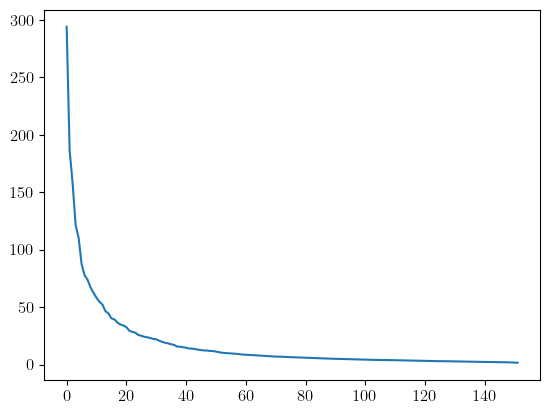

In [ ]:
#Extract the uo and vo components 
USpd = np.nan_to_num(np.array(dsr["uo"][:,0,:lmin,:lmin]))
VSpd = np.nan_to_num(np.array(dsr["vo"][:,0,:lmin,:lmin]))

#Vector snapshot transformation with both components
Spd = np.concatenate((np.transpose(USpd.reshape(USpd.shape[0],USpd.shape[1]*USpd.shape[2])),np.transpose(VSpd.reshape(VSpd.shape[0],VSpd.shape[1]*VSpd.shape[2]))))

#Input matrix
X = Spd[:,:-1]
#Output matrix
Y = Spd[:,1:]

#Rank truncation
r = 40
# SVD of input matrix
U2,Sig2,Vh2 = svd(X, False)
U = U2[:,:r]
Sig = np.diag(Sig2)[:r,:r]
V = Vh2.conj().T[:,:r]

# Build A tilde
Atil = dot(dot(dot(U.conj().T, Y), V), inv(Sig))
print(Atil.shape)
mu,W = eig(Atil)

# Build DMD modes
Phi = dot(dot(dot(Y, V), inv(Sig)), W)

### Eigenvalues plot on unit circle

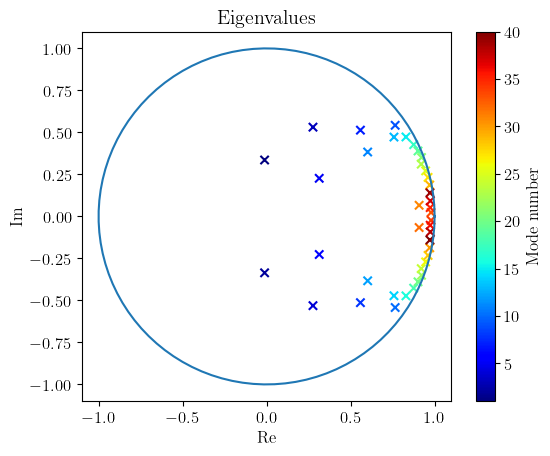

In [36]:
#Plotting eigenvalues
plt.xlabel("Re")
plt.ylabel("Im")    
plt.title("Eigenvalues")
im = plt.scatter(np.real(mu),np.imag(mu),marker = "x",c = np.real(np.linspace(1,r,r)), cmap="jet",vmin=1, vmax=r)
plt.gca().set_aspect('equal')
plt.plot(np.cos(np.linspace(0,2*pi,100)),np.sin(np.linspace(0,2*pi,100)))
plt.colorbar(im, label="Mode number")
plt.savefig("eigenvaluescircle.pdf")


### Modes for the longitudinal velocity

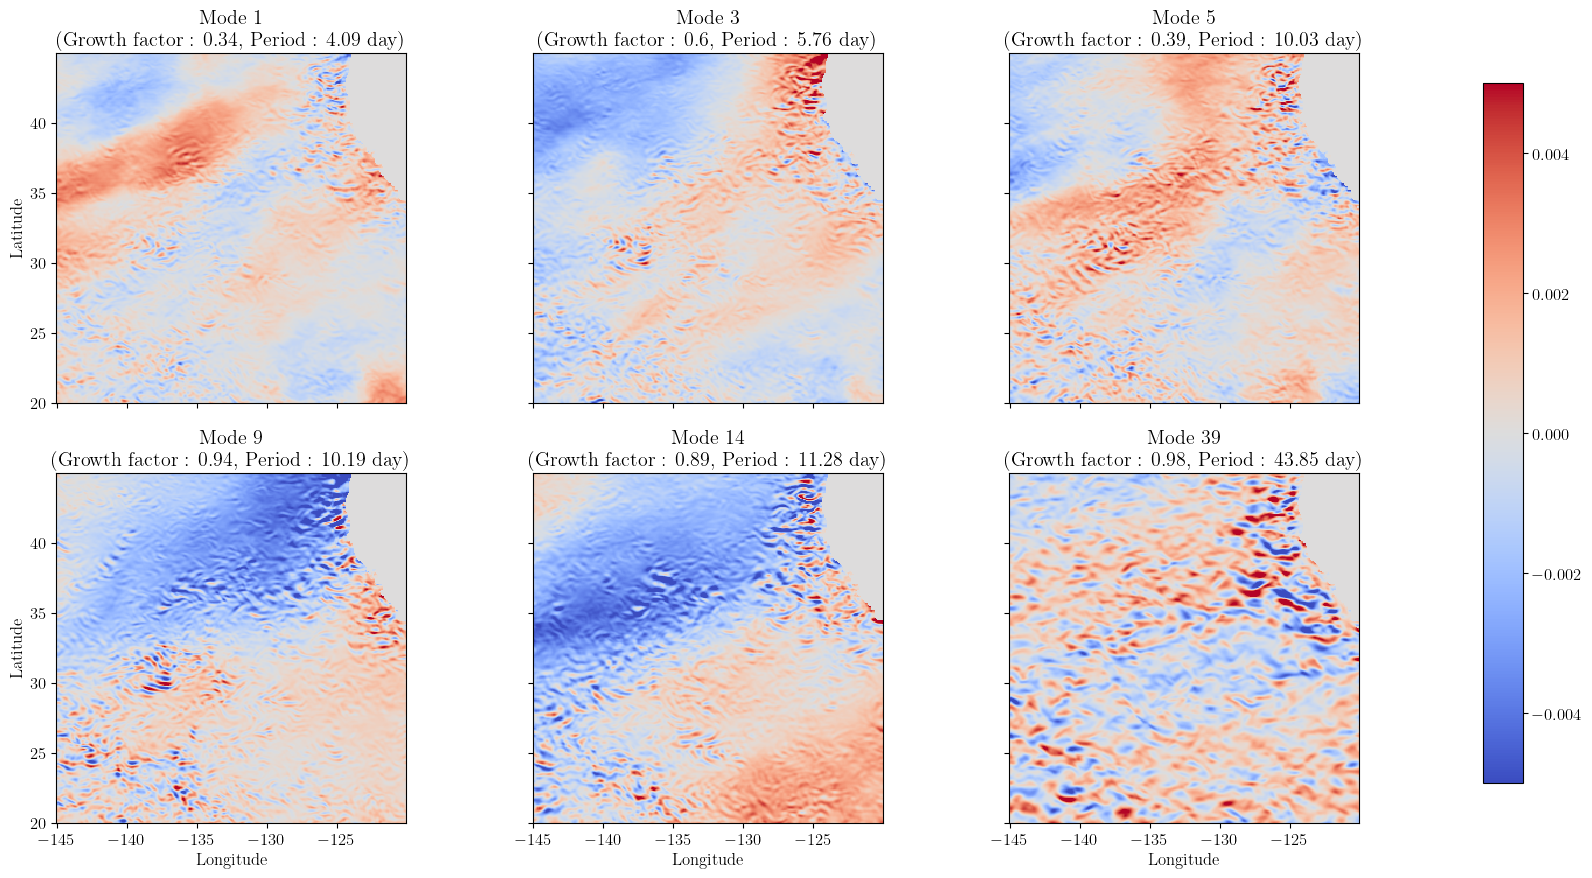

In [37]:

mode = [1,3,5,9,14,39]
fig, axs = plt.subplots(2,3,sharex=True,sharey=True,figsize=(20, 10))

v =0.005
for i,ax in enumerate(axs.flatten()):
    l = abs(mu[mode[i]-1])
    f = atan(imag(mu[mode[i]-1])/real(mu[mode[i]-1]))/(2*pi)
    if f != 0 :
        ax.set_title("Mode "+str(mode[i])+"\n (Growth factor : "+str(round(l,2))+", Period : "+str(abs(round(1/f,2)))+" day)")
    else :
        ax.set_title("Mode "+str(mode[i])+"\n (Growth factor : "+str(round(l,2))+", Period : N/A)")
    if i == 0 or i ==3 :
        ax.set_ylabel("Latitude")
    if i >= 3 :
        ax.set_xlabel("Longitude")
    ax.set_aspect('equal')
    im = ax.pcolormesh(Xc,Yc,np.real(np.split(Phi[:,mode[i]-1],2)[0].reshape(USpd.shape[1],USpd.shape[2])), cmap = "coolwarm",vmin=-v, vmax=v)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)
fig.savefig("fig12.png")

### Modes for the latitudinal velocity

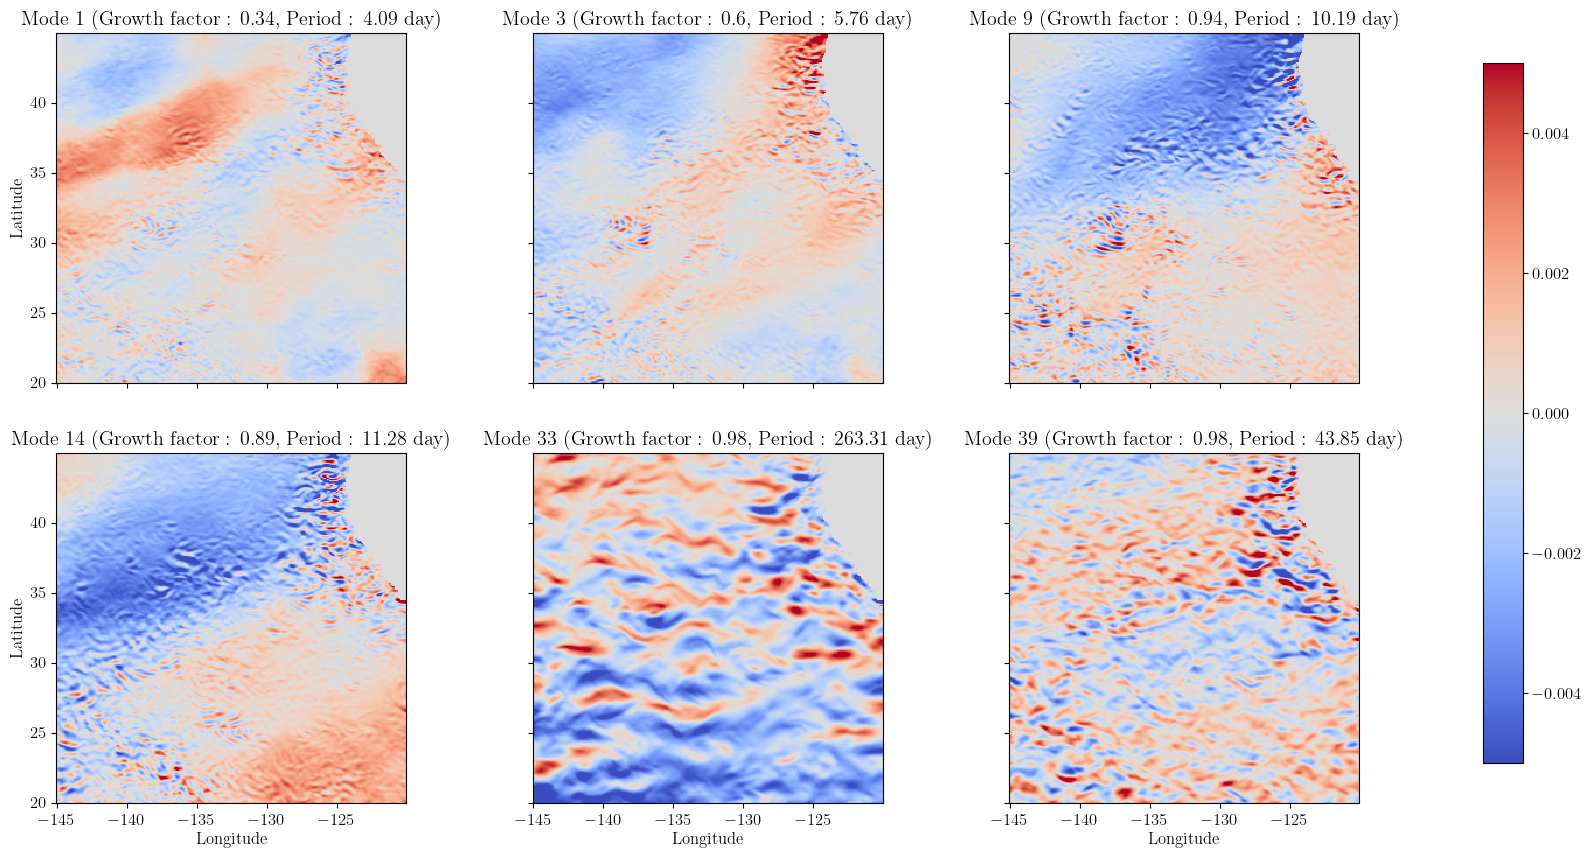

In [ ]:
mode = [1,3,9,14,33,39]
fig, axs = plt.subplots(2,3,sharex=True,sharey=True,figsize=(20, 10))

v =0.005#colormap absolute range
for i,ax in enumerate(axs.flatten()):
    l = abs(mu[mode[i]-1])
    f = atan(imag(mu[mode[i]-1])/real(mu[mode[i]-1]))/(2*pi)
    ax.set_title("Mode "+str(mode[i])+" (Growth factor : "+str(round(l,2))+", Period : "+str(abs(round(1/f,2)))+" day)")
    if i == 0 or i ==3 :
        ax.set_ylabel("Latitude")
    if i >= 3 :
        ax.set_xlabel("Longitude")
    ax.set_aspect('equal')
    im = ax.pcolormesh(Xc,Yc,np.real(np.split(Phi[:,mode[i]-1],2)[0].reshape(USpd.shape[1],USpd.shape[2])), cmap = "coolwarm",vmin=-v, vmax=v)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)

### Quivered modes

C:\Users\albou\AppData\Local\Temp\ipykernel_18196\2526587117.py:24: RuntimeWarning: invalid value encountered in divide
  Un = U/(U**2+V**2)**0.5
C:\Users\albou\AppData\Local\Temp\ipykernel_18196\2526587117.py:25: RuntimeWarning: invalid value encountered in divide
  Vn = V/(U**2+V**2)**0.5


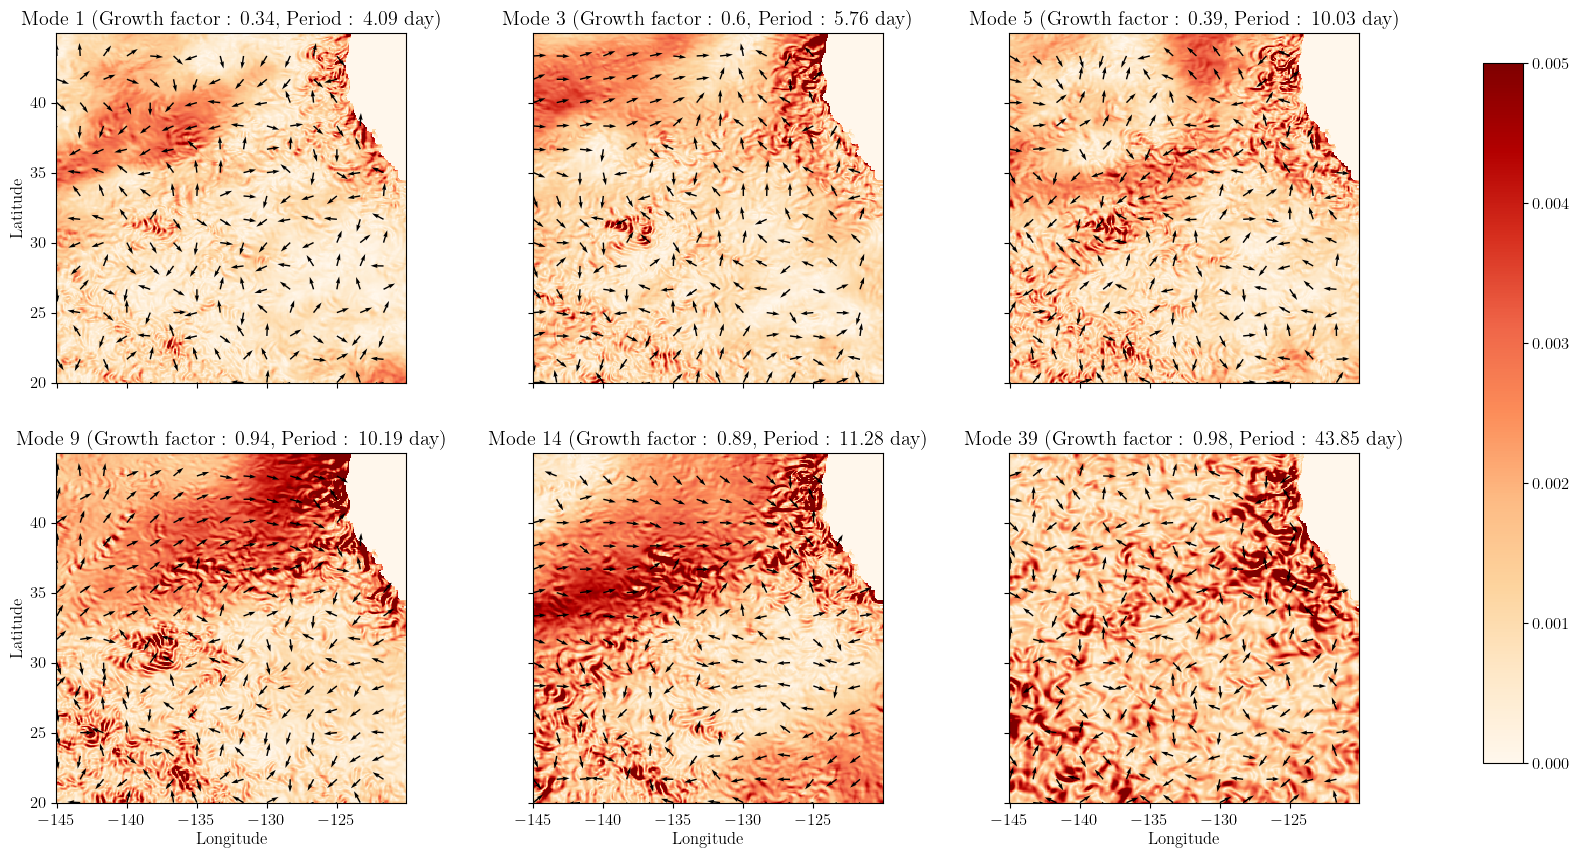

In [ ]:
mode = [1,3,5,9,14,39]
fig, axs = plt.subplots(2,3,sharex=True,sharey=True,figsize=(20, 10))

res = 20#quiver resolution

v =0.005#colormap absolute range

for i,ax in enumerate(axs.flatten()):
    l = abs(mu[mode[i]-1])
    f = atan(imag(mu[mode[i]-1])/real(mu[mode[i]-1]))/(2*pi)
    ax.set_title("Mode "+str(mode[i])+" (Growth factor : "+str(round(l,2))+", Period : "+str(abs(round(1/f,2)))+" day)")
    if i == 0 or i ==3 :
        ax.set_ylabel("Latitude")
    if i >= 3 :
        ax.set_xlabel("Longitude")
    ax.set_aspect('equal')
    U = -np.real(np.split(Phi[:,mode[i]-1],2)[0].reshape(USpd.shape[1],USpd.shape[2]))
    V =  np.real(np.split(Phi[:,mode[i]-1],2)[1].reshape(USpd.shape[1],USpd.shape[2]))
    im = ax.pcolormesh(Xc,Yc,(U**2+V**2)**0.5 , cmap = "OrRd",vmin=0, vmax=v)

    
    Un = U/(U**2+V**2)**0.5
    Vn = V/(U**2+V**2)**0.5



    ax.quiver(Xc[::res],Yc[::res],Un[::res, ::res],Vn[::res, ::res])


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)
fig.savefig("modefield.png")

### Reconstruction and time projection

In [40]:
#Timesteps (original timesteps of the dataset + projected timesteps)
k = 200

b = dot(pinv(Phi),X[:,0])
Psi = np.zeros([r,k],dtype = 'complex')
print(b.shape)
print(pinv(Psi).shape)
print(X[:,0].shape)
for i in range(k):
    Psi[:,i] = multiply(np.power(mu,i),b)

#Compute reconstruction
D = dot(Phi,Psi)

(40,)
(200, 40)
(180000,)


### Original snapshots

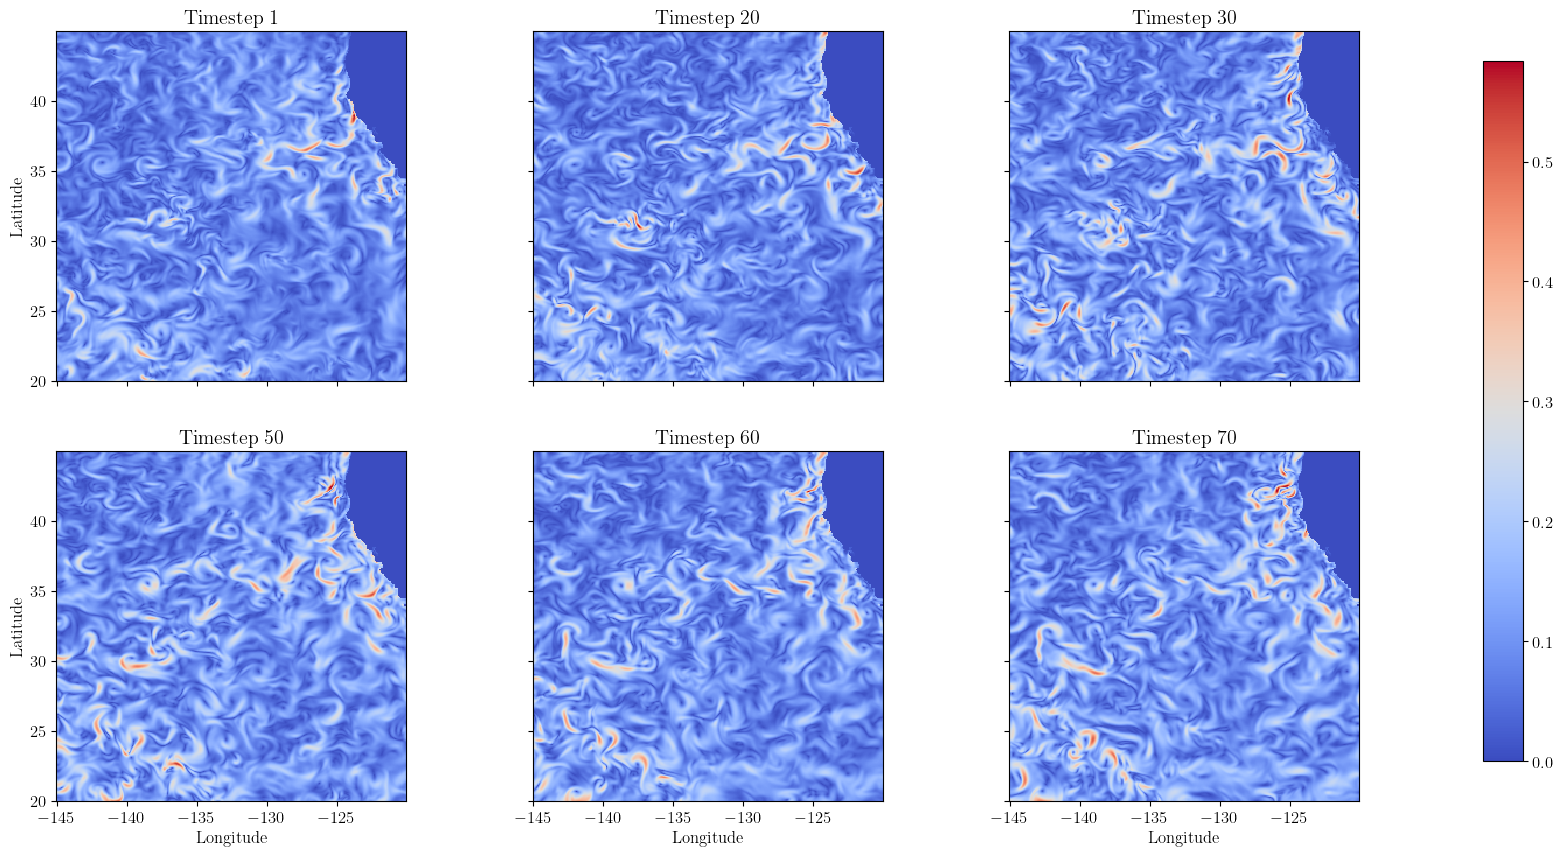

In [41]:
time = [1,20,30,50,60,70]
fig, axs = plt.subplots(2,3,sharex=True,sharey=True,figsize=(20, 10))

res = 10

v =1
for i,ax in enumerate(axs.flatten()):
    ax.set_title("Timestep "+str(time[i]))
    if i == 0 or i ==3 :
        ax.set_ylabel("Latitude")
    if i >= 3 :
        ax.set_xlabel("Longitude")
    ax.set_aspect('equal')
    im = ax.pcolormesh(Xc,Yc,np.real(np.sqrt(USpd[time[i]-1]**2+VSpd[time[i]-1]**2)), cmap = "coolwarm")

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)

### Reconstruction accuracy

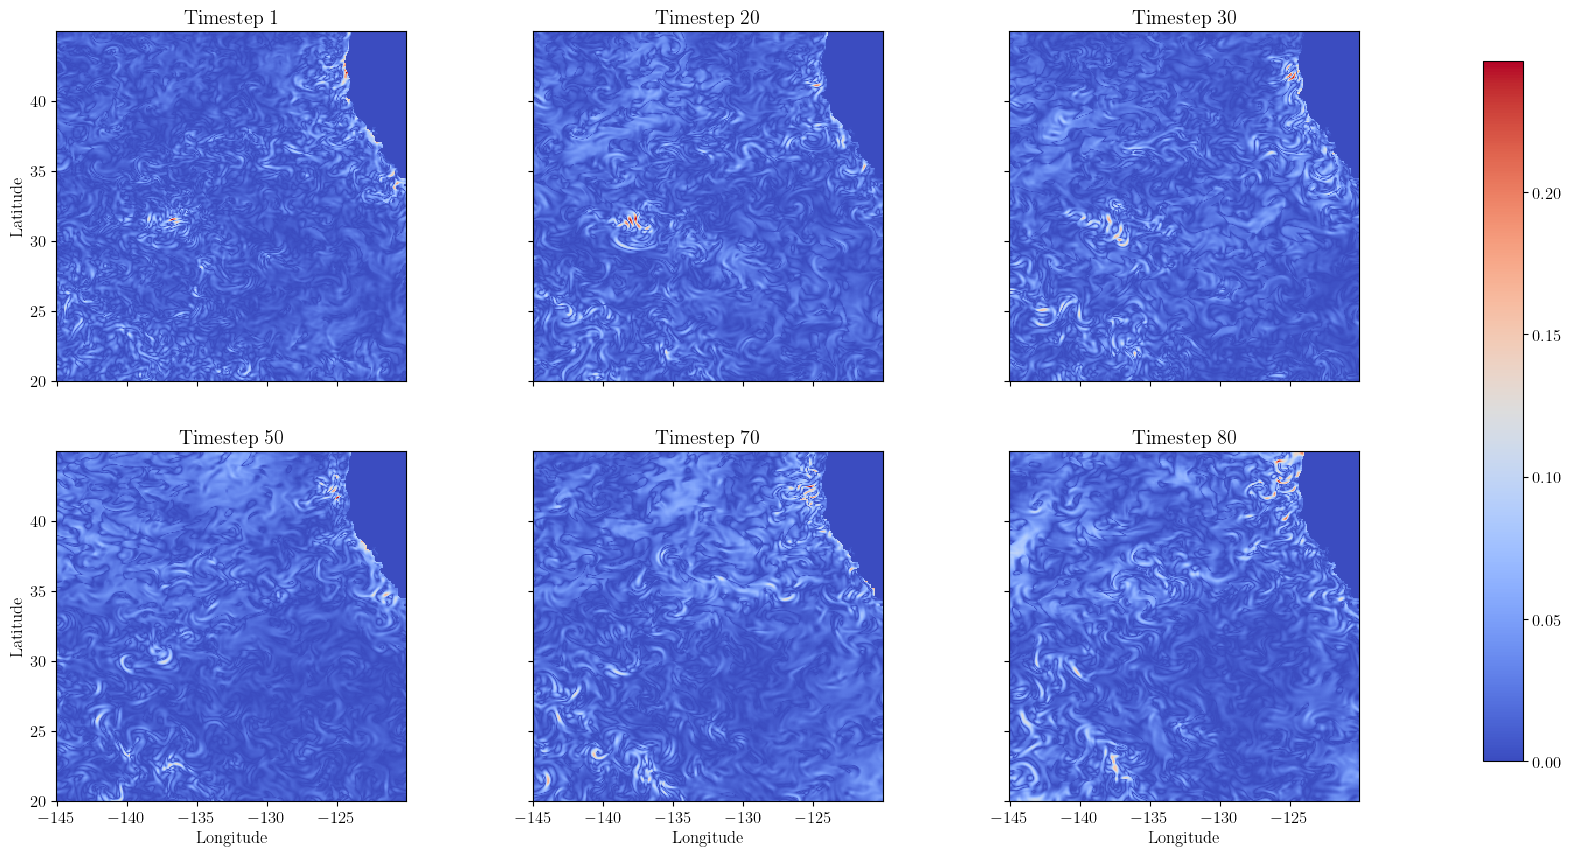

In [42]:
time = [1,20,30,50,70,80]
fig, axs = plt.subplots(2,3,sharex=True,sharey=True,figsize=(20, 10))

res = 10

v =1
for i,ax in enumerate(axs.flatten()):
    ax.set_title("Timestep "+str(time[i]))
    if i == 0 or i ==3 :
        ax.set_ylabel("Latitude")
    if i >= 3 :
        ax.set_xlabel("Longitude")
    ax.set_aspect('equal')
    im = ax.pcolormesh(Xc,Yc,np.abs(np.sqrt(np.real(np.split(D[:,time[i]-1],2)[0].reshape(USpd.shape[1],USpd.shape[2]))**2+np.real(np.split(D[:,time[i]-1],2)[1].reshape(USpd.shape[1],USpd.shape[2]))**2)-np.sqrt(USpd[time[i]-1]**2+VSpd[time[i]-1]**2)), cmap = "coolwarm")

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)

### Snapshot projection

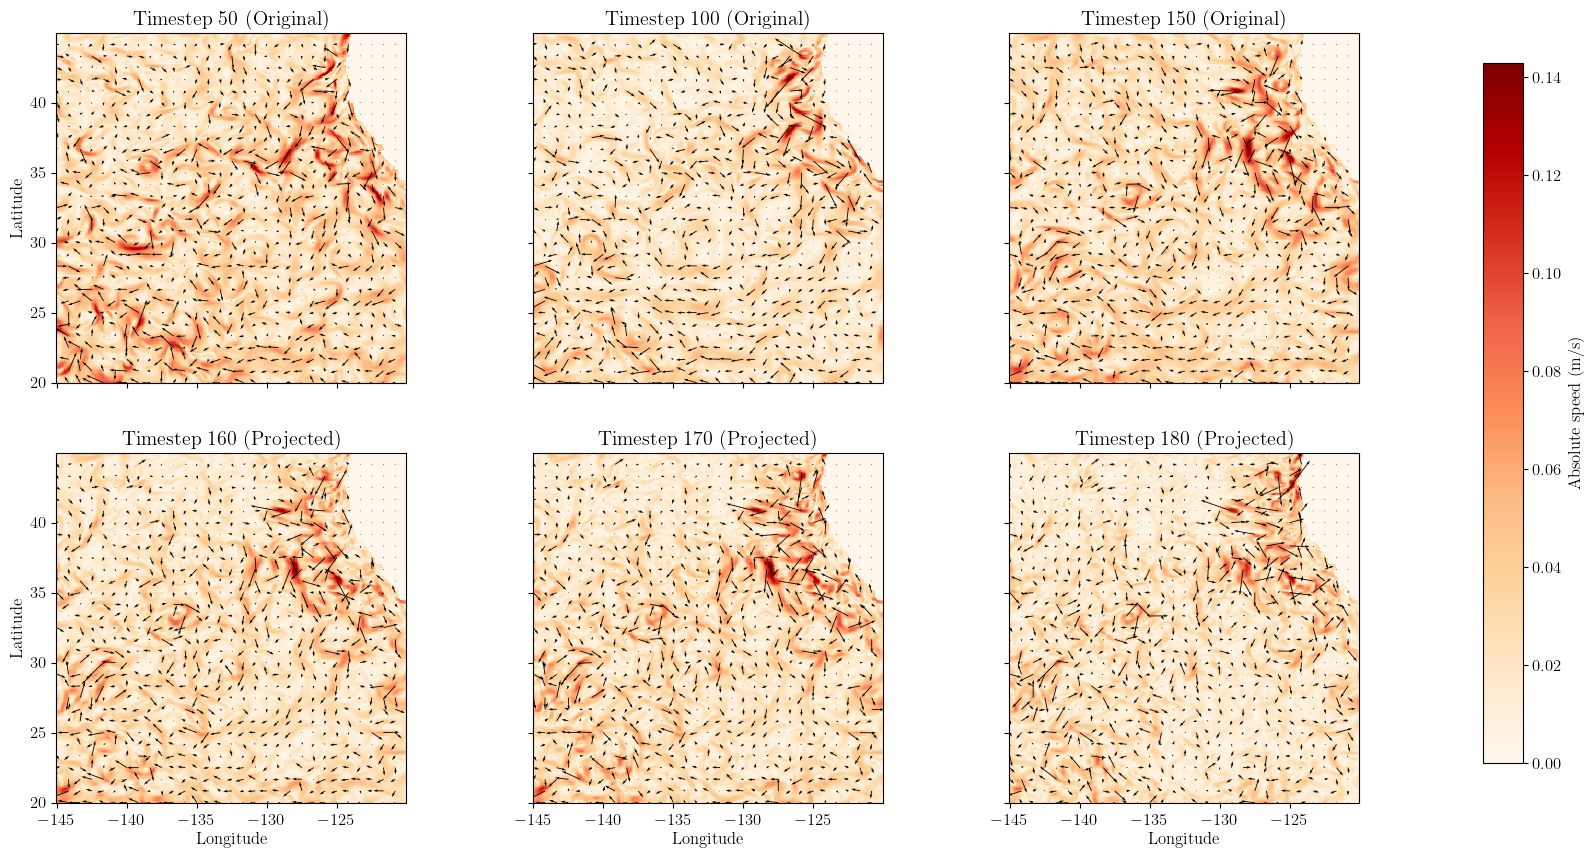

In [43]:
time = [50,100,150,160,170,180]
fig, axs = plt.subplots(2,3,sharex=True,sharey=True,figsize=(20, 10))

res = 10

v =0.5
for i,ax in enumerate(axs.flatten()):
    if time[i] > 150 :
        ax.set_title("Timestep "+str(time[i])+" (Projected)")
    else:
         ax.set_title("Timestep "+str(time[i])+" (Original)")
    if i == 0 or i ==3 :
        ax.set_ylabel("Latitude")
    if i >= 3 :
        ax.set_xlabel("Longitude")
    ax.set_aspect('equal')
    im = ax.pcolormesh(Xc,Yc,np.sqrt(np.real(np.split(D[:,time[i]-1],2)[0].reshape(USpd.shape[1],USpd.shape[2]))**2+np.real(np.split(D[:,time[i]-1],2)[1].reshape(USpd.shape[1],USpd.shape[2]))**2), cmap = "OrRd",vmin=0)
    ax.quiver(Xc[::res],Yc[::res],np.real(np.split(D[:,time[i]-1],2)[0].reshape(USpd.shape[1],USpd.shape[2]))[::res, ::res],np.real(np.split(D[:,time[i]-1],2)[1].reshape(USpd.shape[1],USpd.shape[2]))[::res, ::res])

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax,label="Absolute speed (m/s)")

plt.savefig("timeprojection.png")